<a href="https://colab.research.google.com/github/fpliuzzi/ddam-2324/blob/colab/DDAM_Understanding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [109]:
!pip install ucimlrepo
!pip install pyspark

In [110]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [111]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyspark
from pyspark.ml.feature import StringIndexer
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql.functions import *
from pyspark.mllib.stat import Statistics
from pyspark.sql.types import IntegerType, DoubleType, BooleanType, StringType, TimestampType

In [112]:
spark = SparkSession.Builder().appName('DDAM_Project_Mushrooms').getOrCreate()
sql_ctx = SQLContext(spark)

path = "/content/drive/Shareddrives/DDAM_2023_2024"
mushroom_df = spark.read.options(inferSchema = True, delimiter = ';', header = True).csv(f'{path}/MushroomDataset/secondary_data.csv')


/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [113]:
mushroom_df.show()

+-----+------------+---------+-----------+---------+--------------------+---------------+------------+----------+-----------+----------+---------+------------+----------+---------+----------+--------+---------+-----------------+-------+------+
|class|cap-diameter|cap-shape|cap-surface|cap-color|does-bruise-or-bleed|gill-attachment|gill-spacing|gill-color|stem-height|stem-width|stem-root|stem-surface|stem-color|veil-type|veil-color|has-ring|ring-type|spore-print-color|habitat|season|
+-----+------------+---------+-----------+---------+--------------------+---------------+------------+----------+-----------+----------+---------+------------+----------+---------+----------+--------+---------+-----------------+-------+------+
|    p|       15.26|        x|          g|        o|                   f|              e|        NULL|         w|      16.95|     17.09|        s|           y|         w|        u|         w|       t|        g|             NULL|      d|     w|
|    p|        16.6|    

In [114]:
mushroom_df.dtypes

[('class', 'string'),
 ('cap-diameter', 'double'),
 ('cap-shape', 'string'),
 ('cap-surface', 'string'),
 ('cap-color', 'string'),
 ('does-bruise-or-bleed', 'string'),
 ('gill-attachment', 'string'),
 ('gill-spacing', 'string'),
 ('gill-color', 'string'),
 ('stem-height', 'double'),
 ('stem-width', 'double'),
 ('stem-root', 'string'),
 ('stem-surface', 'string'),
 ('stem-color', 'string'),
 ('veil-type', 'string'),
 ('veil-color', 'string'),
 ('has-ring', 'string'),
 ('ring-type', 'string'),
 ('spore-print-color', 'string'),
 ('habitat', 'string'),
 ('season', 'string')]

Missing Values

In [115]:
missing = mushroom_df.select([count(when(isnull(c), c)).alias(c) for c in mushroom_df.columns])
missing.show()

+-----+------------+---------+-----------+---------+--------------------+---------------+------------+----------+-----------+----------+---------+------------+----------+---------+----------+--------+---------+-----------------+-------+------+
|class|cap-diameter|cap-shape|cap-surface|cap-color|does-bruise-or-bleed|gill-attachment|gill-spacing|gill-color|stem-height|stem-width|stem-root|stem-surface|stem-color|veil-type|veil-color|has-ring|ring-type|spore-print-color|habitat|season|
+-----+------------+---------+-----------+---------+--------------------+---------------+------------+----------+-----------+----------+---------+------------+----------+---------+----------+--------+---------+-----------------+-------+------+
|    0|           0|        0|      14120|        0|                   0|           9884|       25063|         0|          0|         0|    51538|       38124|         0|    57892|     53656|       0|     2471|            54715|      0|     0|
+-----+------------+----

In [116]:
mushroom_df.show()

+-----+------------+---------+-----------+---------+--------------------+---------------+------------+----------+-----------+----------+---------+------------+----------+---------+----------+--------+---------+-----------------+-------+------+
|class|cap-diameter|cap-shape|cap-surface|cap-color|does-bruise-or-bleed|gill-attachment|gill-spacing|gill-color|stem-height|stem-width|stem-root|stem-surface|stem-color|veil-type|veil-color|has-ring|ring-type|spore-print-color|habitat|season|
+-----+------------+---------+-----------+---------+--------------------+---------------+------------+----------+-----------+----------+---------+------------+----------+---------+----------+--------+---------+-----------------+-------+------+
|    p|       15.26|        x|          g|        o|                   f|              e|        NULL|         w|      16.95|     17.09|        s|           y|         w|        u|         w|       t|        g|             NULL|      d|     w|
|    p|        16.6|    

Discrete attribute analysis

In [117]:
cat_cols = [element[0] for element in mushroom_df.dtypes if element[1] == 'string']
print('The numerical columns are')
print(cat_cols)

The numerical columns are
['class', 'cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color', 'stem-root', 'stem-surface', 'stem-color', 'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color', 'habitat', 'season']


In [118]:
for c in cat_cols:
    print(f'column {c} contains {len(mushroom_df.select(c).distinct().collect())} distinct values')

column class contains 2 distinct values
column cap-shape contains 7 distinct values
column cap-surface contains 12 distinct values
column cap-color contains 12 distinct values
column does-bruise-or-bleed contains 2 distinct values
column gill-attachment contains 8 distinct values
column gill-spacing contains 4 distinct values
column gill-color contains 12 distinct values
column stem-root contains 6 distinct values
column stem-surface contains 9 distinct values
column stem-color contains 13 distinct values
column veil-type contains 2 distinct values
column veil-color contains 7 distinct values
column has-ring contains 2 distinct values
column ring-type contains 9 distinct values
column spore-print-color contains 8 distinct values
column habitat contains 8 distinct values
column season contains 4 distinct values


In [119]:
for c in cat_cols:
  print(f'column {c} distinct values are: ')
  results = mushroom_df.select(c).distinct().collect()

  results_string = ''
  for row in results:
    results_string += f"{str(row[c])} "
  print(results_string)
  print()

column class distinct values are: 
e p 

column cap-shape distinct values are: 
x f o p c b s 

column cap-surface distinct values are: 
l g k e h d y w i t s None 

column cap-color distinct values are: 
l g n k e o p w y u b r 

column does-bruise-or-bleed distinct values are: 
f t 

column gill-attachment distinct values are: 
x f e p d a s None 

column gill-spacing distinct values are: 
f d c None 

column gill-color distinct values are: 
g f n k e o p w y u b r 

column stem-root distinct values are: 
f c b r s None 

column stem-surface distinct values are: 
g f k h y i t s None 

column stem-color distinct values are: 
l g f n k e o p w y u b r 

column veil-type distinct values are: 
u None 

column veil-color distinct values are: 
n k e w y u None 

column has-ring distinct values are: 
f t 

column ring-type distinct values are: 
l g m f e z p r None 

column spore-print-color distinct values are: 
g n k p w u r None 

column habitat distinct values are: 
l g m h p d w u 

c

In [120]:
for c in cat_cols:
  print(f'column {c} distinct values counts are: ')
  mushroom_df.groupBy(c).count().orderBy('count', ascending=False).show()

column class distinct values counts are: 
+-----+-----+
|class|count|
+-----+-----+
|    p|33888|
|    e|27181|
+-----+-----+

column cap-shape distinct values counts are: 
+---------+-----+
|cap-shape|count|
+---------+-----+
|        x|26934|
|        f|13404|
|        s| 7164|
|        b| 5694|
|        o| 3460|
|        p| 2598|
|        c| 1815|
+---------+-----+

column cap-surface distinct values counts are: 
+-----------+-----+
|cap-surface|count|
+-----------+-----+
|       NULL|14120|
|          t| 8196|
|          s| 7608|
|          y| 6341|
|          h| 4974|
|          g| 4724|
|          d| 4432|
|          e| 2584|
|          k| 2303|
|          i| 2225|
|          w| 2150|
|          l| 1412|
+-----------+-----+

column cap-color distinct values counts are: 
+---------+-----+
|cap-color|count|
+---------+-----+
|        n|24218|
|        y| 8543|
|        w| 7666|
|        g| 4420|
|        e| 4035|
|        o| 3656|
|        r| 1782|
|        u| 1709|
|        p| 170

Categorical variables bar plot

In [121]:
mushroom_df.createOrReplaceTempView("Mushrooms_Data")

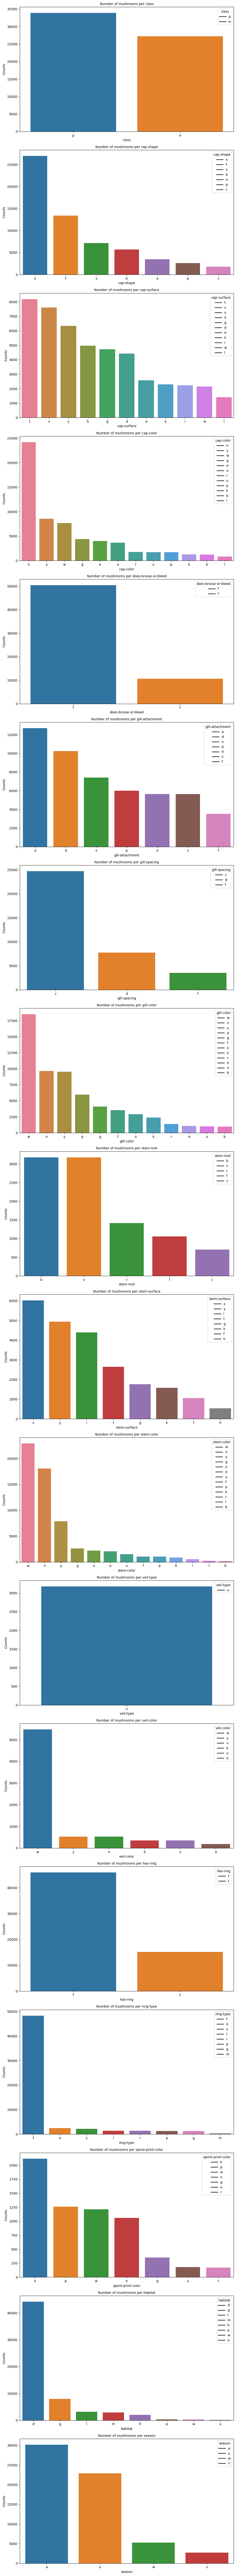

In [129]:
fig, axs = plt.subplots(len(cat_cols), figsize=(10, 6*len(cat_cols)))

for i, col in enumerate(cat_cols):
    col_counts = spark.sql(f"SELECT `{col}`, COUNT(*) as count FROM Mushrooms_Data WHERE `{col}` IS NOT NULL GROUP BY `{col}`").toPandas()
    col_counts = col_counts.sort_values(by='count', ascending=False)
    sns.barplot(x=col, y="count", hue=col, data=col_counts, ax=axs[i])
    axs[i].set_xlabel(col, size=10)
    axs[i].set_ylabel("Counts", size=10)
    axs[i].set_title(f"Number of mushrooms per {col}", size=10)
    unique_col_values = col_counts[col].unique()
    axs[i].legend(title=col, labels=unique_col_values)

plt.tight_layout()
plt.show()

Continuous attribute analysis

In [123]:
num_cols = [element[0] for element in mushroom_df.dtypes if element[1] != 'string']
print('The numerical columns are')
print(num_cols)

The numerical columns are
['cap-diameter', 'stem-height', 'stem-width']


In [124]:
mushroom_df.select(num_cols).describe().toPandas().T

,0,1,2,3,4
summary,count,mean,stddev,min,max
cap-diameter,61069,6.733854492459317,5.264844947062989,0.38,62.34
stem-height,61069,6.581538260001019,3.3700168612896366,0.0,33.92
stem-width,61069,12.149410011626177,10.03595504311756,0.0,103.91


>>> plotting distribution for cap-diameter


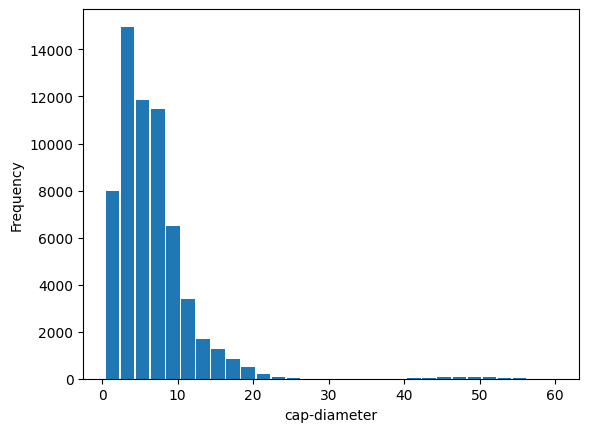

>>> plotting distribution for stem-height


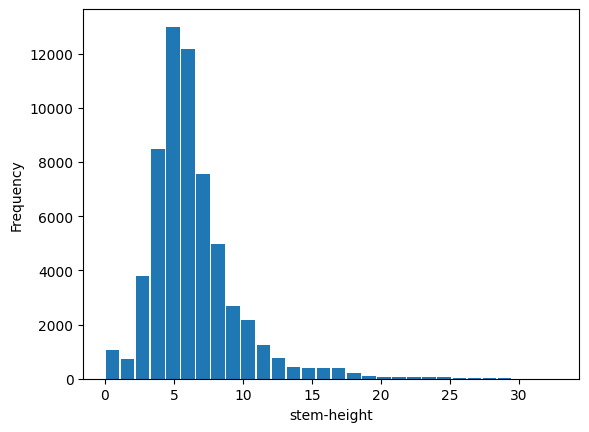

>>> plotting distribution for stem-width


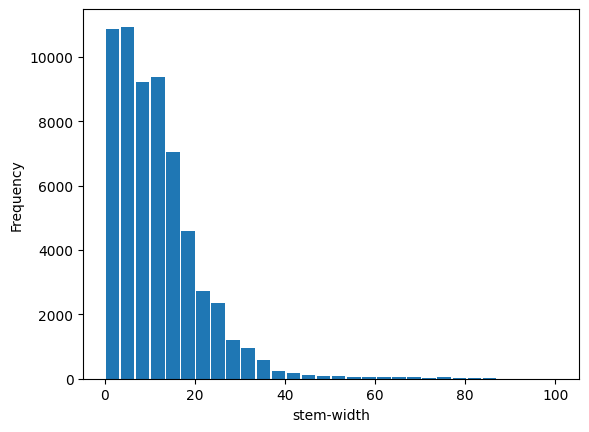

In [132]:
for col in num_cols:
    print(f">>> plotting distribution for {col}")
    query = spark.sql(f'SELECT `{col}` FROM Mushrooms_Data')
    h = query.select(col).rdd.flatMap(lambda x: x).histogram(30)
    dfh = pd.DataFrame(
        list(zip(*h)),
        columns=['bin', 'frequency']
    )
    bins = dfh['bin']
    counts = dfh['frequency']
    plt.hist(bins, len(bins), weights=counts, rwidth=0.9)
    plt.xlabel(f'{col}', size=10)
    plt.ylabel("Frequency", size=10)
    plt.show()

TODO: boxplot per investigare gli outlier

scatterplot (per correlazione 2+ attributi)

correlation matrix